In [1]:
import numpy as np
import pandas as pd

# cross validation purposes: create the cartesian product between the chosen values sets
from itertools import product 

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dataset

In [2]:
cmp = pd.read_csv("commViolUnnormData.txt", na_values='?')

In [3]:
# drop first non predictive features (communityname, state, countyCode, communityCode, "fold")
pred_features = cmp[cmp.columns[5:-18]]
regr_values = cmp[cmp.columns[-18:]]

In [4]:
# load in a dictionary the meanings of all the variables {variable_1:description_1, ...}
with open("variables_description.txt") as file:
    content = file.readlines()
    
variables_description = {}
for line in [c.strip() for c in content]:
    spl = line.split(':')
    variables_description[spl[0][3:]]=spl[1][1:]
    
#example
variables_description["PctHousOwnOcc"]

'percent of households owner occupied (numeric - decimal)'

# Drop features with a lot of missing values

It has been chosen to drop those features that have not at least 25% of missing values over the total:

In [5]:
print("Before dropping: {} features".format(str(pred_features.shape[1])))

#drop features that contain at least some threshold (from the total) of NaN values
cut_tresh = 0.75
to_drop = pred_features.columns[pred_features.count() < pred_features.shape[0]*cut_tresh]

pred_features = pred_features.drop(columns=to_drop)

print("After dropping: {} features".format(str(pred_features.shape[1])))

Before dropping: 124 features
After dropping: 102 features


# Imputing on features matrix

For those features that have still some missing values, we compute a representative number based on some strategy (*mean*, *median* or *most_frequent*) on computed on the non-missing ones:

In [6]:
from collections import Counter

def value_withStrategy(v, strat):
    if strat == "mean":
        return np.mean(v)
    if strat == "median":
        return np.median(v)
    if strat == "most_frequent":
        return Counter(v).most_common(1)[0][0]
    print("Invalid imputing strategy!")
        
def imputing(df, strategy):
    # for each column that contain at least 1 NaN value...
    for nanCol in np.unique(np.where(pred_features.isna())[1]):
        nanRows = np.where(pred_features.iloc[:,nanCol].isna())[0] #find NaN rows for the current column
        available = df.iloc[~nanRows, nanCol]
        value = value_withStrategy(available, strategy) #compute the filling value
        df.iloc[nanRows, nanCol] = value

In [7]:
imputing(pred_features, "mean");

# Choose the Dependent Variable and drop possible missing values rows on it

Of course, we cannot predict anything of a sample if the dependent variable for that row is missing; but just for now try to chose the regression feature (out of 18 possible ones) analysing its distribution:

In [8]:
print(regr_values.columns)

Index(['murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies',
       'robbPerPop', 'assaults', 'assaultPerPop', 'burglaries', 'burglPerPop',
       'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons',
       'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object')


In [9]:
regr_values.describe()

murders   murdPerPop        rapes  rapesPerPop     robberies  \
count  2215.000000  2215.000000  2007.000000   2007.00000   2214.000000   
mean      7.764786     5.859296    28.046338     36.25848    237.952123   
std      58.166468     9.156829   105.616135     34.23975   2250.720788   
min       0.000000     0.000000     0.000000      0.00000      0.000000   
25%       0.000000     0.000000     2.000000     11.53500      5.000000   
50%       1.000000     2.170000     7.000000     26.92000     19.000000   
75%       3.000000     8.365000    19.000000     51.47000     70.000000   
max    1946.000000    91.090000  2818.000000    401.35000  86001.000000   

        robbPerPop      assaults  assaultPerPop    burglaries   burglPerPop  \
count  2214.000000   2202.000000    2202.000000   2212.000000   2212.000000   
mean    162.612597    326.528156     378.004605    761.236890   1033.430203   
std     234.486624   1987.947941     438.238599   3111.702756    763.354442   
min       0.000000      0.000000       0.000000      2.000000     16.920000   
25%      27.647500     18.000000      94.187500     95.000000    511.690000   
50%      74.800000     56.000000     226.525000    205.000000    822.715000   
75%     187.155000    180.000000     504.387500    508.000000   1350.232500   
max    2264.130000  62778.000000    4932.500000  99207.000000  11881.020000   

           larcenies    larcPerPop      autoTheft  autoTheftPerPop  \
count    2212.000000   2212.000000    2212.000000      2212.000000   
mean     2137.629295   3372.979150     516.692586       473.965628   
std      7600.573464   1901.316145    3258.164244       504.666026   
min        10.000000     77.860000       1.000000         6.550000   
25%       392.000000   2040.080000      30.000000       156.952500   
50%       747.000000   3079.510000      75.000000       302.355000   
75%      1675.000000   4335.410000     232.500000       589.775000   
max    235132.000000  25910.550000  112464.000000      4968.590000   

            arsons  arsonsPerPop  ViolentCrimesPerPop  nonViolPerPop  
count  2124.000000   2124.000000          1994.000000    2118.000000  
mean     30.907721     32.153682           589.078922    4908.241804  
std     180.125248     39.240900           614.784518    2739.708901  
min       0.000000      0.000000             0.000000     116.790000  
25%       1.000000      7.670000           161.700000    2918.070000  
50%       5.000000     21.080000           374.060000    4425.450000  
75%      16.000000     42.852500           794.400000    6229.280000  
max    5119.000000    436.370000          4877.060000   27119.760000

Looking at the table, the only variable that seems somewhat equally distributed between minimum, quantiles and maximum is the last one: *"nonViolPerPop"*

In [10]:
def drop_naSample(df, vals):
    idxRow = np.where(vals.isna())[0]
    return df.drop(index=idxRow).values, vals.drop(index=idxRow).values.reshape(-1,1)

In [11]:
dep_var = "nonViolPerPop"
data,values = drop_naSample(pred_features, regr_values[dep_var])
variables_description[dep_var]

'total number of non-violent crimes per 100K popuation (numeric - decimal) potential GOAL attribute (to be predicted)'

# Exploratory Data Analysis

Lets look at the distribution of the chosen dependent and how the different predictors are correlated with it:

In [12]:
regr_values[dep_var].describe()

count     2118.000000
mean      4908.241804
std       2739.708901
min        116.790000
25%       2918.070000
50%       4425.450000
75%       6229.280000
max      27119.760000
Name: nonViolPerPop, dtype: float64

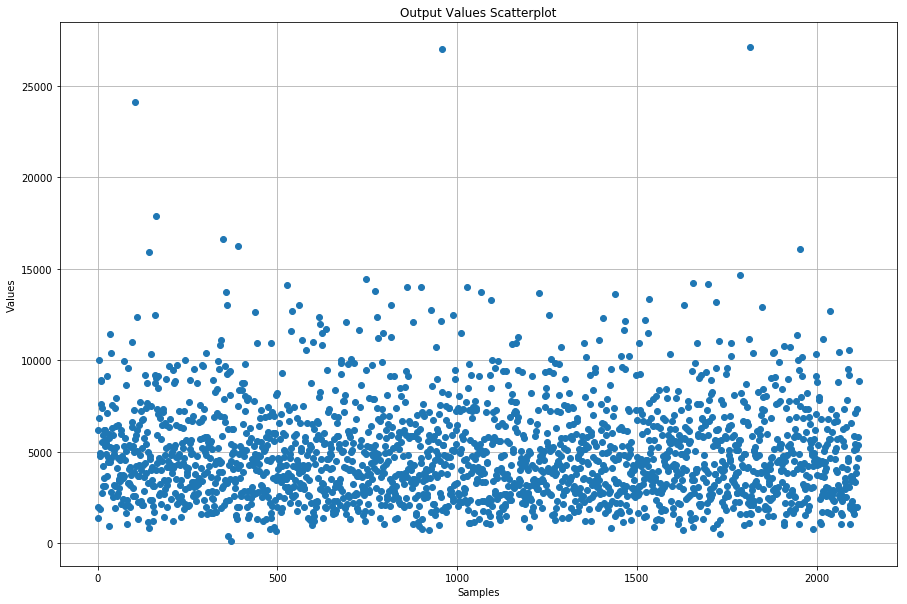

In [13]:
plt.figure(figsize=(15,10))
plt.plot(values, 'o')
plt.title("Output Values Scatterplot")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.grid()

[ 1466.9385  4167.2355  6867.5325  9567.8295 12268.1265 14968.4235
 17668.7205 20369.0175 23069.3145 25769.6115]


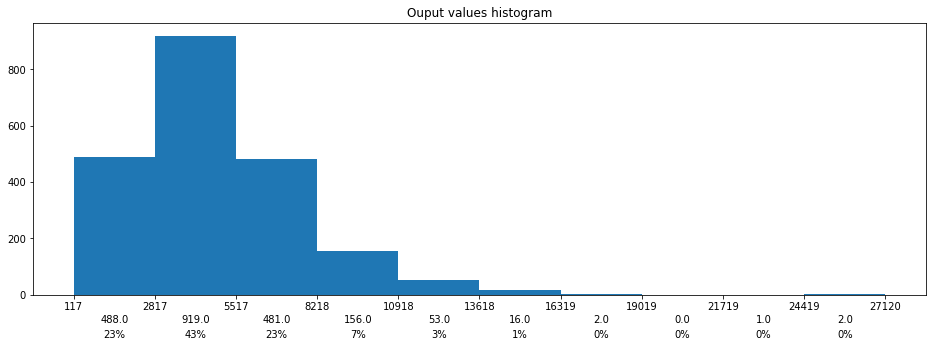

In [14]:
plt.figure(figsize=(16,5))
counts,bins,_ = plt.hist(values,bins=10)

bin_centers = 0.5 * np.diff(bins) + bins[:-1]
print(bin_centers)
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center')
    
plt.title("Ouput values histogram")
plt.xticks(bins)
plt.show()

Both of the two graphs (scatterplot and histogram over the regression values) outline the presence of possible outliers, but a deep study of them it is needed before decide to discard them for good (perhaps a PCA procedure could tell us if they are just some cluster outliers or some proper regression ones). <br><br>
At this point, try to see whether a bivariate correlation between a feature and the output exists: treat the predictor and the dependent as two separate random variables and compute the Pearson coefficient of them:$$ \mbox{Pearson}(x,y)=\frac{cov(x,y)}{std(x)\cdot std(y)}$$ the result will be either equal to: <ul><li>$\simeq 1 \to$ the two random variable are perfectly correlated (an increase of the first will results in an increase of the second, and the other way round);</li><li>$\simeq -1 \to$ the two random variables are strongly inversely correlated;</li><li>$\simeq 0 \to$ there is absolutely no correlation between the two.</li></ul>

In [15]:
def sample_pearsonCorrelation_withOutput(X, y):
    # r_x_y = cov(x,y)/(stdev(x)*stdev(y))
    _,d = X.shape
    corr = np.empty((d,1))
    
    y_centered = y-np.mean(y)
    y_stdev = np.std(y)
    
    for i in range(d):
        current = X[:,i]
        corr[i] = np.mean(np.multiply(current-np.mean(current), y_centered))/(np.std(current)*y_stdev)
        
    return corr

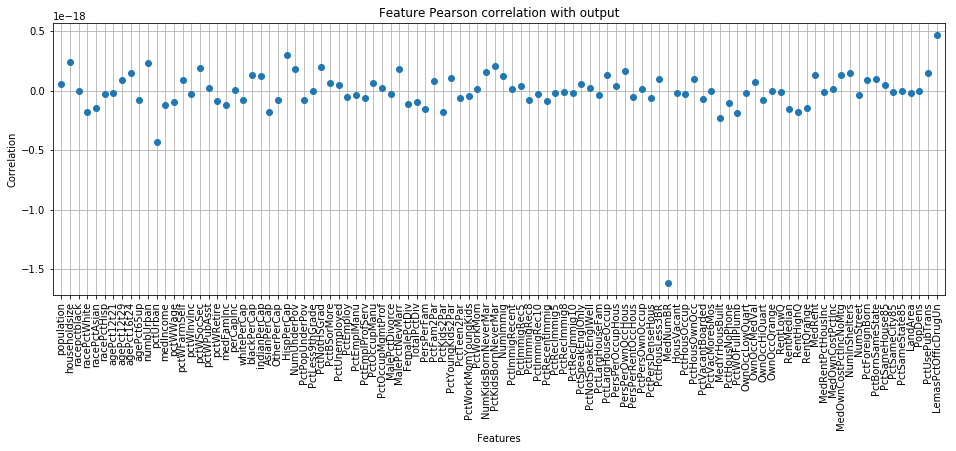

In [16]:
p_corr = sample_pearsonCorrelation_withOutput(data, values)

plt.figure(figsize=(16,5))
plt.plot(p_corr, "o")
plt.title("Feature Pearson correlation with output")
plt.xticks(range(len(pred_features.columns)), pred_features.columns, rotation=90)
plt.xlabel("Features")
plt.xlim(-1,102)
plt.ylabel("Correlation")
plt.grid()

Glancing at the scale of the y axis (*1e-18*), we can safely assume that neither of the variables is directly correlated with the regression output (all the values are $\approx 0$).<br>
This behaviour is better shown by the box-plots below (note how all the different bins of the previous histogram are roughly placed on the same horizontal line, in this sense we can consider each bin as a sort of class):

In [17]:
d = data.shape[1]
plt.figure(figsize=(15,700))

labels = []
toRender_flags = []
for bin_idx in range(len(bins)-1):
    labels.append("{}<=v<{}".format(round(bins[bin_idx],0), round(bins[bin_idx+1],0)))
    toRender_flags.append((values>=bins[bin_idx]) & (values<bins[bin_idx+1]))
    
for var_idx in range(d):
    ax = plt.subplot(d,1,var_idx+1)
    plt.title("Feature #{}: \"{}\"".format(var_idx, pred_features.columns[var_idx]))
    plt.ylabel("Values")
    plt.grid()
    bPlots = []
    for flag in toRender_flags:
        bPlots.append(data[flag.flatten(),var_idx])
        
        if data[flag.flatten(),var_idx].shape[0]==0: continue
        # if there are some possible outliers or samples that span very widely,
        # the logaritmic scale might help visualise
        #if np.var(data[flag.flatten(),var_idx])>1000:
        if np.median(data[flag.flatten(),var_idx])/np.max(data[flag.flatten(),var_idx]) < .06:
            plt.yscale(value="log")
        
    plt.boxplot(bPlots)
    ax.set_xticks(range(1,len(labels)+1))
    ax.set_xticklabels(labels,rotation=-10)

plt.tight_layout()

/Users/danilo/.conda/envs/bcb/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/danilo/.conda/envs/bcb/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


# Outliers Detection

*-- TBD* <br>
A thourough study from scratch of outliers detection is needed here, but for now it feels like it exceeds the course final project.

# Normalisation

Some learning procedures depend on computing the distance between variables (the l2 or l1 regularisations for instance), so we need to normalise each predictor in order to make them work properly:

In [18]:
def normalise(matrix, strat):
    for j in range(matrix.shape[1]):
        mi = np.min(matrix[:,j])
        ma = np.max(matrix[:,j])
        di = ma-mi
        if (di > 1e-6):
            if strat=="0_mean,1_std":
                matrix[:,j] = (matrix[:,j]-np.mean(matrix[:,j]))/np.std(matrix[:,j])
            elif strat=="[0,1]":
                matrix[:,j] = (matrix[:,j]-mi)/di
            elif strat=="[-1,1]":
                matrix[:,j] = 2*((matrix[:,j]-mi)/di)-1
            else:
                print("Invalid normalisation strategy!")
        else:
            matrix[:,j] = 0

In [19]:
strategy = "[-1,1]"
normalise(data,strategy)
normalise(values,strategy)

# Train-Test Split

In [20]:
def trainTest_split(in_matrix, out_vect, train_amount=0.7):
    n,_ = in_matrix.shape

    trVl_Amount = int(n*train_amount) #training-validation amount
    indexes = np.random.permutation(n)
    idxTrVl = np.sort(indexes[0:trVl_Amount])
    idxTs = np.sort(indexes[trVl_Amount:])

    return in_matrix[idxTrVl], in_matrix[idxTs], out_vect[idxTrVl], out_vect[idxTs]

In [21]:
trainVal_data, test_data, trainVal_values, test_values = trainTest_split(data, values, train_amount=0.7)

# Evaluation Metrics

In [22]:
class Regression_evaluationMetric:
    def __init__(self, true, predicted):
        self.true = true.flatten()
        self.predicted = predicted.flatten()
        self.residuals = self.true-self.predicted
        self.resVariance = np.var(self.residuals)
    
    def meanSquareError(self):
        return np.mean(np.square(self.residuals))
    
    def rootMeanSquareError(self):
        return np.sqrt(np.mean(np.square(self.residuals)))
    
    def meanAbsoluteError(self):
        return np.mean(np.abs(self.residuals))
    
    def rSquared(self):
        ss_residual = np.sum(np.square(self.residuals))
        ss_total = np.sum(np.square(self.true-np.mean(self.true)))        
        return 1 - ss_residual/ss_total
    
    def adjusted_rSquared(self, p):
        n = self.true.shape[0]
        return 1-(1-self.rSquared())*((n-1)/(n-p-1))


# Variable Selection - Models Definition

## 0. K-fold Cross Validation

In order to perform some statistical robust decisions in our model, we need to perform some repeated testing and then analyse the results (this version of the cross-validation is general purpose and can be used as long as the chosen predictor provides both a *fit* and a *predict* methods and the user builds a dictionary with the exact paramenters name of the fit method as keys):

In [23]:
from itertools import product

def kFold_crossValidation_selectionGrid(k, parameters_dict, train_data, train_values, predictor, verbose=False):
    nVal,_ = train_data.shape
    
    # Validation indexes adjustment -------------------------------
    elemPerFold, remainder = np.divmod(nVal,k) #the remainder will be distributed across the firsts folds
    valIdxList = []
    start = 0

    # in each fold put as many samples as the division quotient +1 if the remainder is still positive
    # then decrease the division remainder by 1
    for i in range(k): 
        end = start+elemPerFold+int(remainder>0)
        valIdxList.append(np.arange(start,end)) 
        remainder -= 1
        start = end
    
    # Cross validation --------------------------------------------
    params_names = parameters_dict.keys()
    params_product = list(product(*parameters_dict.values())) # build all the hyp-par combination
    val_results = np.empty((len(valIdxList),len(params_product)))
    
    for row, valIdx in enumerate(valIdxList): # for each fold
        if verbose: print("#{} fold:".format(row+1))
        for col, params in enumerate(params_product):
            
            if verbose:
                update = col*100/len(params_product) # just print completion rate
                print("\t["+"#"*(int(update/5))+" "*(int((100-update)/5))+"] {}%".format(update))
                     
            arg_dict = {k:v for k,v in zip(params_names,params)} # {argument_name1:argument_value1, ... }
            
            predictor.fit(train_data[~valIdx], train_values[~valIdx], **arg_dict)
            pred = predictor.predict(train_data[valIdx])
            
            rem = Regression_evaluationMetric(trainVal_values[valIdx], pred)
            #val_results[row,col] = rem.rSquared()
            val_results[row,col] = rem.rootMeanSquareError()
            
    selected = np.argmin(val_results.mean(axis=0))
    return params_product[selected]

## 1. Matching Pursuit - Not Working (use the sklearn model)

Matching Pursuit is a greedy algorithm that is able to find approximate solution to problems, it encompasses the following steps:
<ol>
    <li>Initialise the residual, the coefficient vector and the indexes set;</li>
    <li>Find the variable most correlated with the residual;</li>
    <li>Update the index set with the newfound variable;</li>
    <li>Update the coefficient vector;</li>
    <li>Update the residual</li>
</ol>
In general these are the roughly steps that compose this very class of optimisers, and, specifically to the MP procedure, the variable selection rule consists of the maximum residual projection: at each step the selected column is the one that is able to describe better the output vector in a least square sense.

### Project class definition

In [24]:
class matchingPursuit:
    def __init__(self, iterations, weights = None, indexes = None):
        self.iterations = iterations
        self.weights = weights
        self.indexes = indexes
        
    def fit(self, data_matrix, output_vect):
        residual = output_vect.copy()
        self.weights = np.zeros((data_matrix.shape[1], 1))
        self.indexes = []

        #data_norm2 = np.sqrt(np.sum(np.square(data_matrix), axis=0))
        data_norm2 = np.linalg.norm(data_matrix, ord=2, axis=0).reshape(1,-1)

        for i in range(self.iterations):
            
            # project each column on the current residuals
            projection = np.matmul(residual.T, data_matrix)
            # find the most correlated variable: the one that in norm maximise the projections
            k = np.argmax(np.divide(np.square(projection), data_norm2))
            self.indexes.append(k)
            
            distance = projection[0,k]/np.linalg.norm(data_matrix[:,k], ord=2)
            self.weights[k,0] += distance # update the solution vector: canonical basis over the found column
            residual -= np.matmul(data_matrix, self.weights) # update the residual

        return self
    
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [25]:
mp = matchingPursuit(iterations=50)
mp.fit(trainVal_data, trainVal_values)
mp.sort_featureImportances(columns=pred_features.columns)

[('NumStreet', array([-7.73406672e+77])),
 ('population', array([0.])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('numbUrban', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.])),
 ('blackPerCap', array([0.])),
 ('indianPerCap', array([0.])),
 ('AsianPerCap', array([0.])),
 ('OtherPerCap', array([0.])),
 ('HispPerCap', array([0.])),
 ('NumUnderPov', array([0.])),
 ('PctPopUnderPov', array([0.])),
 ('PctLess9thGrade', array([0.])),
 ('PctNotHSGrad', array([0.])),
 (

In [26]:
pred = mp.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 5.655648297155039e+152
Root Mean Square Error: 7.708717001688143e+77
R^2 score: -1.297802067218575e+157


### SkLearn Class

In [27]:
from sklearn.linear_model import orthogonal_mp
omp_coef = orthogonal_mp(trainVal_data, trainVal_values)
np.where(omp_coef)[0]

array([11, 34, 37, 38, 44, 55, 60, 76, 85, 92])

In [28]:
pred = np.matmul(test_data, omp_coef)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.026183790491251607
Root Mean Square Error: 0.16199074733430022
R^2 score: 0.42690756607124036


## 2. L1 Penalty (Lasso) with Proximal Gradient

Lasso is a procedure that performs both variable selection and regularisation in order to obtain sparse interpretable results; it can be seen as a convex relaxation of the best subset selection model ( $\|\cdot\|_0$ regularisation).<br>
The functional is:
$$ \min_{w\in \mathbb{R}^d}\frac{1}{n}\sum^n_{i=1}(y_i-f_w(x_i))^2+\lambda\|w\|_1 $$
Clearly, it is composed by an error term (quadratical, so convex and smooth) subject to the constraint $\sum^d_{i=1}|w_i|\leq t$ (convex non smooth); from this very representation it might appears clear why the functional induces a sparse solution respect to the classical $l$2 constraint $(\sum^d_{i=1}w_i)^2\leq t$ : <img src="img/L1_and_L2_balls.png">
Generally this kind of problems are solved by tools of non-smooth convex optimisation, yet a simple and powerful procedure called *Iterative Soft Thresholding Algorithm* makes use of the theory behind the proximity operator and specifically the proximal gradient methods.<br>
Briefly, the proximal operator can be seen as a generalisation of the projection performed by iteratively (soft) thresholding the gradient step:
$$w_{t+1}=Prox_{\gamma\lambda}(w_t-\frac{\gamma}{n}X^\top(Xw_t-y))$$
where $\gamma$ represents the gradient step (convergenced is ensured with $\gamma=\frac{n}{2\|X^\top X\|}$) and $\lambda$ is the chosen regulariser; finally $Prox_{\gamma\lambda}$ is the defined entrywise operator:
$$Prox_{\gamma\lambda}(w)^j=
\begin{cases}
w^j-\gamma\lambda&\mbox{if }w^j>\gamma\lambda\\
0&\mbox{if }w^j\in[-\gamma\lambda,\gamma\lambda]\\
w^j-\gamma\lambda&\mbox{if }w^j<\gamma\lambda
\end{cases}$$

### Project class definition

In [29]:
class lasso_regression: # Iterative Soft Thresholding Algorithm
    def __init__(self, iterations, weights=None):
        self.iterations = iterations
        self.weights = weights
        
    def fit(self, data_matrix, output_vect, _lambda):
        n,d = data_matrix.shape
        self.weights = np.zeros((d,1))
        
        # convergence step-size: n/(2*||X^t*X||_2)
        step = n/(2*np.linalg.norm(np.matmul(data_matrix.T, data_matrix), ord=2))
        softTresh = step*_lambda

        for i in range(self.iterations): # or convergence...
            # gradient step of the mse formulation
            resid = np.matmul(data_matrix, self.weights) - output_vect
            grad_descent = (step/n)*np.matmul(data_matrix.T, resid)
            self.weights -= grad_descent

            # proximal operator
            upper = self.weights > softTresh  # elem to be reduced
            lower = self.weights < -softTresh # elem to be increased
            self.weights[upper] -= softTresh
            self.weights[lower] += softTresh
            self.weights[(~upper) & (~lower)] = 0

        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights.flatten()), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights.flatten()), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [30]:
k = 5
params_dict = {"_lambda":[0.0001,0.0005,0.001,0.01,0.1,1]}

lr = lasso_regression(iterations=1000)

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, lr)[0]
print("Best regulariser: {}".format(win_regulariser))

lr.fit(trainVal_data, trainVal_values, win_regulariser)
#lr.sort_featureImportances(columns=pred_features.columns)
lr.sort_featureImportances()

Best regulariser: 0.0001


[(38, 0.054777185037957976),
 (41, 0.04988817009463656),
 (40, 0.04568014433450078),
 (44, -0.04513139630500424),
 (101, 0.039127915101938616),
 (43, -0.038989012810626965),
 (2, 0.03735993427944479),
 (46, -0.03637918591622719),
 (45, -0.036065619993400334),
 (77, 0.034434830439466935),
 (72, -0.03353392844922082),
 (50, 0.03294564582634761),
 (25, 0.030783078269503664),
 (28, 0.02978759740947845),
 (76, 0.028548474263891503),
 (21, 0.026154886326909633),
 (75, -0.022261837640712438),
 (85, -0.021964099887060225),
 (94, -0.02126337096030929),
 (98, 0.02120564618535245),
 (74, 0.02115023438544127),
 (71, 0.020828702035348125),
 (3, -0.020714254540324335),
 (9, 0.0194317875439514),
 (70, -0.019266146896155006),
 (55, 0.018701091065756237),
 (23, 0.01861022097113613),
 (20, 0.018063140738026166),
 (11, 0.017992569039077037),
 (26, 0.017818005225016174),
 (4, 0.01767844018105691),
 (27, 0.017490403956713398),
 (0, 0.01741032304910017),
 (10, 0.01737393741128914),
 (91, 0.01731060816688124

In [31]:
pred = lr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.025562509098032937
Root Mean Square Error: 0.16008772408700328
R^2 score: 0.4402935422215898


### SkLearn Class

In [32]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
lasso.fit(trainVal_data, trainVal_values)
np.where(lasso.coef_)[0]

array([11, 28, 34, 38, 40, 44, 55, 70, 76, 77, 85, 94])

In [33]:
pred = lasso.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.02679172770352766
Root Mean Square Error: 0.163871395803291
R^2 score: 0.41352357028966125


## 3. Random Forest

### Project Decision Tree class definition

"Tree-based regression models are known for their simplicity and efficiency when dealing with domains with large number of variables and cases. Regression trees are obtained using a fast divide and conquer greedy algorithm that recursively partitions the given training data into smaller subsets. The use of this algorithm is the cause of the efficiency of these methods. However, it can also lead to poor decisions in lower levels of the tree due to the unreliability of estimates based on small samples of cases. Methods to deal with this problem turn out to be nearly as important as growing the initial tree.<br>
[...]<br>
In spite of their advantages regression trees are also known for their instability (Breiman, 1996). A small change in the training set may lead to a different choice when building a node, which in turn may represent a dramatic change in the tree, particularly if the change occurs in top level nodes. Moreover, the function approximation provided by standard regression trees is highly non-smooth leading to very marked function discontinuities. Although there are applications where this may be advantageous, most of the times the unknown regression function is supposed to have a certain degree of smoothness that is hardly captured by standard regression trees."<br>
[Luís Fernando Raínho Alves Torgo - INDUCTIVE LEARNING OF TREE-BASED REGRESSION MODELS]<br>


Again, the least square error criterion is the simplest yet powerful procedure that is able to obtain the model parameters that can decently approximate the wanted regression surface:
$$\frac{1}{n}\sum^n_{i=1}(y_i-f_w(x_i))^2$$
The following theorem, thanks to the MSE formulation, holds for the LS criterion:<br>
<u>*The constant k that minimises the expected value of the squared error is the mean value of the target variable.*</u>  $k_{l}=\frac{1}{n_l}\sum_{S_l}y_i$ , where $n_l$ represents the cardinality of the leaf samples set $S_l$.<br>
From this formulation we can easily state the error for a leaf $a$: $\mbox{Err}_a=\frac{1}{n_a}\sum_{S_a}(y_i-k_a)^2$ (note how it recalls the definition of variance for a node $a$ ) and more generally the error of a tree $T$: $\mbox{Err}_T=\frac{1}{n}\sum_{a\in L}\sum_{S_a}(y_i-k_a)^2$ where $L$ denote the set of all the leaf nodes for $T$.

Each internal node sends its samples in two subnodes, so we must also define the error of choosing a split over the others: $\mbox{Err}_{(s,j)}=\frac{n_l\cdot Err_l+n_r\cdot Err_r}{n_j}$ (weighted average of the left and right subnodes of the internal node $j$).<br>
Having all the ingredient, we can now state:<br>
<li>The best split $s^*$ for a internal node is the one that maximises
$$\Delta\mbox{Err}_{(s,j)}=\mbox{Err}_j-\mbox{Err}_{(s,j)}$$
Consequently, what we really want to do is minimise the second factor in the formulation (since the first one do not depend on the split that we are searching):
$$\min_s\mbox{Err}_{(s,j)} = \min_{l,r}\frac{n_l\cdot Err_l+n_r\cdot Err_r}{n_j}=\min_{l,r}\big(\frac{n_l}{n_j}{Err}_l+\frac{n_r}{n_j}{Err}_r\big)$$
Focusing, for instance, on the error of the left subnode:
$${Err}_l=\frac{1}{n_l}\sum_{S_l}(y_i-k_l)^2=\big(\frac{\sum_{S_l}({y_i}^2)}{n_l}-\big(\frac{\sum_{S_l}{y_i}}{n_l}\big)^2\big)\hspace{1cm}\mbox{(from the variance definition)}$$
This computation clearly needs a double pass on the data: the former for computing the average of the squares and the latter for obtaining the squared average; but joining it with the right subnodes and carrying out the math:
$$\mbox{Err}_{(s,j)}=\frac{n_l}{n_j}\cdot\big(\frac{\sum_{S_l}({y_i}^2)}{n_l}-\big(\frac{\sum_{S_l}{y_i}}{n_l}\big)^2\big)+\frac{n_r}{n_j}\cdot\big(\frac{\sum_{S_r}({y_i}^2)}{n_r}-\big(\frac{\sum_{S_r}{y_i}}{n_r}\big)^2\big)=\frac{\sum_{S_l}({y_i}^2)}{n_j}-\frac{(\sum_{S_l}{y_i})^2}{n_jn_l}+\frac{\sum_{S_r}({y_i}^2)}{n_j}-\frac{(\sum_{S_r}{y_i})^2}{n_jn_r}=\frac{\sum_{S_l}({y_i}^2)+\sum_{S_r}({y_i}^2)}{n_j}-\frac{1}{n_j}\big(\frac{(\sum_{S_l}{y_i})^2}{n_l}+\frac{(\sum_{S_r}{y_i})^2}{n_r}\big)$$
It is easy to note that the first addend in the formulation does not really depend on how the split is performed, since the summation is carried out after the square operator the result will not change.
Finally, we can recap stating that in order to maximise the descent in the error we must maximise the second term in the previous expression:
$$\max_s{\Delta\mbox{Err}}_{(s,j)}\Rightarrow\max_{l,r}\big(\frac{(\sum_{S_l}{y_i})^2}{n_l}+\frac{(\sum_{S_r}{y_i})^2}{n_r}\big)$$

Moreover decision trees are often used for variable ranking: each time a feature is chosen among the others as the most predictive at a certain point, it means that this very predictor will have an impact on the decision function (we can expect that this dependance is much higher when considering internal nodes nearer to the root), so the algorithm can keep track of the error descent ($\Delta{\mbox{Err}}_{(s,j)}$) for each variable, updating its score when it has been chosen.

In [34]:
class NumericalDecisionTree_regressor: # Least Square Regression Tree with either fixed parameter or pruning
    class Node:
        def __init__(self, isLeaf=False, feature=None, feature_importance=None, cut=None, average=None,
                     left=None, right=None):
            self.isLeaf = isLeaf
            self.feature = feature # if internal, on wich feature it executes the split
            self.feature_importance = feature_importance # solution variance reduction
            self.cut = cut # if internal, threahold value for the cut
            self.avg = average # mean of seen training values
            self.left = left
            self.right = right

        def print_tree(self):
            if self.left: self.left.print_tree()
            if self.cut:
                print("Feature: {}, cut: {}\n".format(self.feature, self.cut))
            else:
                print("Leaf => {}\n".format(self.avg))
            if self.right: self.right.print_tree()

        def print_tree_indented(self, level=0):
            if self.right: self.right.print_tree_indented(level+1)
            if self.cut:
                print("|    "*level+"{} => {}".format(self.feature, self.cut))
            else:
                print("|    "*level+"Leaf: {}".format(self.avg))                
            if self.left: self.left.print_tree_indented(level+1)
            
    def __init__(self, root=None, feature_importances=None):
        self.root = root
        self.feature_importances = feature_importances

        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=False):
        
        self.feature_importances = {k:0 for k in range(X.shape[1])}
        
        if not post_pruning:
            self.root = self.learn(X, y.flatten(), depth, minElems_perLeaf)
        else:
            # train dataset, pruning dataset
            X_trn, X_val, y_trn, y_val = trainTest_split(X, y.flatten(), train_amount=0.7)
            self.root = self.learn(X_trn, y_trn, depth, minElems_perLeaf)
            self.prune(X_val, y_val)
        
        return self
        
    def learn(self, X, y, depth, minElems_perLeaf):
        n, d = X.shape

        if depth==0 or n<=minElems_perLeaf: # leaf # or fraction error of the root node??? 
            return self.Node(isLeaf=True, average=np.mean(y))
            
        best_costDescent = np.float("-inf") # split that maximise the error descent

        for i1 in range(d):
            sorted_idx = np.argsort(X[:,i1])
            sorted_x, sorted_y = X[sorted_idx, i1], y[sorted_idx]

            s_right, s_left = np.sum(sorted_y), 0
            n_right, n_left = n, 0

            for i2 in range(n-1):
                s_left += sorted_y[i2]
                s_right -= sorted_y[i2]
                n_left += 1
                n_right -= 1
                
                if sorted_x[i2]<sorted_x[i2+1]: # for a different value
                    # try to maximise this value: it is directly correlated 
                    # to the possible split information gain
                    new_costDescent = (s_left**2)/n_left + (s_right**2)/n_right
                    if new_costDescent > best_costDescent:
                        best_costDescent = new_costDescent
                        best_feature = i1
                        best_cut = (sorted_x[i2]+sorted_x[i2+1])/2
                        
        # update the importance for the selected feature
        feature_importance = np.var(y) - (np.sum(np.square(y))-best_costDescent)/n
        self.feature_importances[best_feature] += feature_importance

        left_idxs = X[:,best_feature] < best_cut
        
        return self.Node(feature=best_feature, feature_importance=feature_importance,
                         cut=best_cut, average=np.mean(y),
                         left = self.learn(X[left_idxs], y[left_idxs], depth-1, minElems_perLeaf),
                         right = self.learn(X[~left_idxs], y[~left_idxs], depth-1, minElems_perLeaf))
    
    def prune(self, X, y):
        # for statistics purposes check errors on different dataset portions and average them
        # in order to decide whether to prune or not (same code of k-fold cross-validation)
        n,_ = X.shape
        folds = 5
        elemPerFold, remainder = np.divmod(n, folds)
        foldsIdxsList = []
        start = 0
        for i in range(folds): 
            end = start+elemPerFold+int(remainder>0)
            foldsIdxsList.append(np.arange(start,end)) 
            remainder -= 1
            start = end
        
        # recursive: start checking if the root receive a possible positive pruning from its sons
        self.test_pruning(self.root, X, y, foldsIdxsList)
        return self
    
    def test_pruning(self, node, X, y, foldIdxs):
        if node.isLeaf: # leaf: start point of new possible pruning
            return True
        
        # check sons response: if one of them is negative to be pruned it means that it performs an important
        # predictive split
        if not self.test_pruning(node.left, X, y, foldIdxs) or not self.test_pruning(node.right, X, y, foldIdxs):
            return False
        
        # else proceed with testing the goodness of the current node split
        folds = len(foldIdxs)
        results = np.empty(folds)

        # not pruned errors on different folds
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        not_prunErr = np.mean(results)

        # pruned errors on different folds
        node.isLeaf = True
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        # if pruning improves the prediction RMSE then keep current node as leaf
        node.isLeaf = np.mean(results) <= not_prunErr
        
        if node.isLeaf:
            # lower feature importance computed during training phase
            self.feature_importances[node.feature] -= node.feature_importance 
            node.left = None
            node.right = None
            
        return node.isLeaf
            
    def predict(self, X):
        if self.root is None:
            raise Exception("Tree not initialised! need to first fit the model")

        n,_ = X.shape
        y = np.empty(n)
        
        for i in range(n):
            current = self.root
            while not current.isLeaf:
                if X[i,current.feature] < current.cut:
                    current = current.left
                else:
                    current = current.right
                
            y[i] = current.avg
        
        return y
                
    def pprint(self):
        self.root.print_tree_indented()
        
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

As it has been said, decision trees might suffer from overfitting in their deeper level and this might clearly lead to bad generalisation properties; two procedure have been coded and carried out in order to prevent this behaviour: the first one leverages on cross-validation for establishing the right depth and leaf samples amount, while the second implements a greedy post-pruning algorithm that builds a very deep and possibly overfitting tree and then test each node (starting by the leaves) on a separate validation set in order to decide whether it is better to cut down a split or not.

#### with fixed depth and min elements per leaf (to be cross-validated)

In [35]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=10, minElems_perLeaf=5)
ndt.pprint()

|    |    |    |    Leaf: 0.029848198179681873
|    |    |    37 => 0.6903744229782869
|    |    |    |    |    |    |    |    Leaf: -0.7108779762621174
|    |    |    |    |    |    |    17 => -0.8550627240143369
|    |    |    |    |    |    |    |    Leaf: -0.7705486964335156
|    |    |    |    |    |    74 => -0.932815241915267
|    |    |    |    |    |    |    |    Leaf: -0.7260023619624063
|    |    |    |    |    |    |    10 => -0.9696606270699717
|    |    |    |    |    |    |    |    |    |    Leaf: -0.7703897015772709
|    |    |    |    |    |    |    |    |    72 => 0.9267024215829678
|    |    |    |    |    |    |    |    |    |    Leaf: -0.8234476923587789
|    |    |    |    |    |    |    |    46 => 0.6433756805807621
|    |    |    |    |    |    |    |    |    Leaf: -0.7680623649917028
|    |    |    |    |    43 => 0.6988531785360331
|    |    |    |    |    |    |    Leaf: -0.5148585507446033
|    |    |    |    |    |    19 => -0.25827428224733784
|    |    | 

In [36]:
#ndt.sort_featureImportances(columns=pred_features.columns)
ndt.sort_featureImportances()

[(5, 0.0803490938527358),
 (6, 0.027154093889931945),
 (89, 0.021507273453699467),
 (60, 0.020330135390773014),
 (44, 0.01947528893275196),
 (13, 0.01939073424960194),
 (49, 0.018062424039214438),
 (1, 0.016697003180630717),
 (68, 0.016128061634979377),
 (17, 0.01498959573102118),
 (36, 0.014301077924392532),
 (78, 0.014142143803499855),
 (46, 0.013940521770284972),
 (77, 0.013774394237720509),
 (41, 0.013117638673581473),
 (79, 0.012222991962903194),
 (26, 0.01207288686133147),
 (22, 0.01202082562067558),
 (0, 0.011411124491914407),
 (47, 0.010500937487622448),
 (69, 0.010352972926102308),
 (90, 0.01021875066200425),
 (14, 0.010040009825991666),
 (98, 0.010037956441536919),
 (92, 0.009369749139663534),
 (39, 0.008991222873962871),
 (40, 0.008632919065487346),
 (82, 0.008201135280406242),
 (96, 0.008166303915103916),
 (56, 0.007977028730780988),
 (9, 0.007449645750676213),
 (19, 0.007441303829063833),
 (37, 0.007428621980221109),
 (72, 0.0073423978683222245),
 (31, 0.007201148470467603

In [37]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.04917865307786489
Root Mean Square Error: 0.22178429563500004
R^2 score: -0.074251177940593


#### with pruning

In [38]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=10, post_pruning=True)
ndt.pprint()

|    |    |    |    Leaf: 0.029848198179681873
|    |    |    37 => 0.6903744229782869
|    |    |    |    |    |    |    |    |    |    Leaf: -0.8160837122731314
|    |    |    |    |    |    |    |    |    45 => 0.8359255202628696
|    |    |    |    |    |    |    |    |    |    Leaf: -0.8540999996173261
|    |    |    |    |    |    |    |    2 => -0.970001034447088
|    |    |    |    |    |    |    |    |    Leaf: -0.7794961072800509
|    |    |    |    |    |    |    38 => -0.6139275766016713
|    |    |    |    |    |    |    |    Leaf: -0.8637541404837004
|    |    |    |    |    |    4 => -0.8815537362828776
|    |    |    |    |    |    |    |    |    Leaf: -1.0
|    |    |    |    |    |    |    |    1 => 0.2255434782608693
|    |    |    |    |    |    |    |    |    Leaf: -0.9032224973771402
|    |    |    |    |    |    |    2 => -0.9869659666908037
|    |    |    |    |    |    |    |    Leaf: -0.8264255129466623
|    |    |    |    |    49 => -0.9999488206961522
|    |

In [39]:
#ndt.sort_featureImportances(columns=pred_features.columns)
ndt.sort_featureImportances()

[(44, 0.034142008611332944),
 (43, 0.018814825618384608),
 (99, 0.01845327941909514),
 (49, 0.018066002216963046),
 (38, 0.01745076448464145),
 (2, 0.01654911362048217),
 (98, 0.015509776885092828),
 (14, 0.013923290363644085),
 (47, 0.013255034948887644),
 (85, 0.012766261121460069),
 (62, 0.012644719661610649),
 (18, 0.012184958683506473),
 (68, 0.012159097073220068),
 (37, 0.011940180844538769),
 (17, 0.011719573653282932),
 (61, 0.011664145985645503),
 (40, 0.010191757422343706),
 (89, 0.009748832604902457),
 (23, 0.009573069380303799),
 (94, 0.009203712956288995),
 (46, 0.009145593777613063),
 (77, 0.008829089855785179),
 (24, 0.008608166443936947),
 (71, 0.008458855183241618),
 (13, 0.00837068421898504),
 (72, 0.008224127259538758),
 (29, 0.007096955523864454),
 (25, 0.006356569386874833),
 (79, 0.0054782071720548475),
 (33, 0.00531554248812623),
 (91, 0.005220806263894595),
 (26, 0.004363814724060557),
 (11, 0.00425644068703169),
 (86, 0.004244587594366502),
 (92, 0.004201029384

In [40]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.04091530492415265
Root Mean Square Error: 0.20278279542400507
R^2 score: 0.10193769436539757


### Decision Tree SkLearn Class

In [41]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(trainVal_data, trainVal_values)
np.flip(np.argsort(dtr.feature_importances_))

array([ 44,  46,  43,  68,  41,  78,  49,  92,  97,  72,  37,  77,  96,
        69,  79,  89,  22,   2,  55,  95,  26,  98,  28,  40,  27,  86,
        47,  60,  31,  39,  18,  36,  16,   6, 100,  21,   0,  38,  54,
        19,  13,  75,  14,  64,  99,  94,  71,  91,  82,  48,  50,   7,
         3,  61,  88,  80,   8,  56,  62,  10,  87,  74,  66,  15,   5,
        65,  23,  24,   4,  90,  35,  32,  57, 101,  93,  29,  53,  81,
        58,  51,  34,  63,  12,   9,   1,  17,  73,  30,  85,  84,  42,
        76,  33,  20,  52,  59,  83,  45,  25,  11,  67,  70])

In [42]:
pred = dtr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.05250899407304441
Root Mean Square Error: 0.22923535663716724
R^2 score: -0.14764471896352016


### Project Random Forest class definition

It has been stated that decision tree are highly dependant on the samples that have been fed, so training a decision tree on different matrices might end up on building predictors that are very different in terms of results (this might happen during a k-fold cross-validation procedure for instance); so statistician started to build ensemble method in order to try to build more stable estimators and in the specific case of decision tree they came up with the idea of Random Forests.
The building concepts of this kind of predictors are:
<ol>
    <li><i>Bootstrap Aggregating</i> (Bagging): the idea refers to being able to take aside a portion of the training set for a tree and tune it on the remaining samples (this is often referenced as Bootstrapping), this procedure is repeated for each tree declared in the forest and at every iterations the cases are taken with replacement (this should ensure the tree independency); once trained, the prediction phase will take a vote for each tree and then averages the obtained results (procedure calles Aggregating); this procedure generally helps reducing the variance of the prediction model, thus leading to more stable results; moreover the bootstrap samples could be used for quantifying the prediction error for each tree that have not used them during the training phase, in this way we have formed a test set essentially for free;</li>
    <li><i>Random Subspace Method</i>: similarly to bagging, this concepts expects to random subsample the feature space with replacement for each weak learner, it should help avoiding to keep choosing certain variables as the most descriptive on a certain samples set, when they would maybe behave poorly on a different one (for this reason bagging and random subspacing are often paired expecially on a particular setting of problems, where the number of feature is much bigger than the number of cases available)</li>
</ol>

In [43]:
class NumericalRandomForest_regressor:
    def __init__(self, n_trees, trees=None, bootstrap_subSpace=None, outOfBag_error=None, feat_importances=None):
        self.n_trees = n_trees
        self.trees = trees
        self.bootSamplesIdxs_SubSp = bootstrap_subSpace
        self.oob_error = outOfBag_error
        self.feature_importances = feat_importances
        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=True, verbose=False):
        n,d = X.shape
        
        self.trees = []
        self.bootSamplesIdxs_SubSp = []
        self.feature_importances = {k:0 for k in range(d)}
        
        n_learn = int(n/3) # Bootstrap amount to be taken aside
        # random subspace method amount
        d_learn = int(d/self.n_trees) if int(d/self.n_trees) >= int(np.sqrt(d)) else int(np.sqrt(d))
                
        # Fitting the forest -----------------------------------
        for i in range(self.n_trees):
            if verbose: print("\tFitting #{} tree".format(i+1))
            
            bootstrap_idxs = np.sort(np.random.permutation(n)[:n_learn])
            subspace_idxs = np.sort(np.random.permutation(d)[:d_learn])
            self.bootSamplesIdxs_SubSp.append((bootstrap_idxs, subspace_idxs))
                        
            dt = NumericalDecisionTree_regressor()
            
            self.trees.append(dt.fit(X[~bootstrap_idxs][:,subspace_idxs], y[~bootstrap_idxs],
                                     depth=depth, minElems_perLeaf=minElems_perLeaf, post_pruning=post_pruning))
            
            for k,v in dt.feature_importances.items():
                self.feature_importances[subspace_idxs[k]] += v
        
        # Out-Of-Bag Estimate for the forest -------------------
        oob_errors = []
        for sampleIdx in range(n):
            # finds all the tree that not have current sample in their bootstrapp set (not trained on it)
            # and the relative subspace on wich they have been trained
            missingTreesIdx_subspc = [(idx,subspace_idxs) for idx,(bootstrap_idxs,subspace_idxs)
                                      in enumerate(self.bootSamplesIdxs_SubSp)
                                      if sampleIdx not in bootstrap_idxs]

            if len(missingTreesIdx_subspc) == 0: continue
            
            regr_results = np.empty(len(missingTreesIdx_subspc)) # regression estimate of the selected trees
            for i, (missingTree_idx, tree_subSpace) in enumerate(missingTreesIdx_subspc):
                # reshape in order to correctly use the decision_tree.predict(...): it needs a matrix (num,dim)
                # while numpy matrix indexing returns (dim,)
                regr_results[i] = self.trees[missingTree_idx].predict(X[sampleIdx,tree_subSpace].reshape(1,-1))
            
            # done at this level of granularity because a sample might end up in 
            # being part of no bootstrap set of any tree (so we cannot predict wich value in y will be used)
            oob_errors.append(np.square(y[sampleIdx]-np.mean(regr_results)))
            #oob_errors.append(r2_score(np.mean(regr_results),y[sampleIdx]))
            
        self.oob_error = np.sqrt(np.mean(oob_errors))
        return self
        
    def predict(self,X):
        if len(self.trees)==0:
            raise Exception("Trees not initialised! need to first fit the model")

        n,_ = X.shape
        results = np.empty((self.n_trees,n))
        for row, (tree,(_,subspace_idxs)) in enumerate(zip(self.trees, self.bootSamplesIdxs_SubSp)):
            results[row] = tree.predict(X[:,subspace_idxs])
            
        return np.mean(results,axis=0)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

#### try to find the optimal number of trees for the problem

In [44]:
n_trees = [1,10,20,30,50,70,100,150,200]
oob_errors = np.empty(len(n_trees))

for i, num_t in enumerate(n_trees):
    print("Training {} tree".format(num_t)+'s'*(num_t!=1))
    nrf = NumericalRandomForest_regressor(num_t)
    # no train and test, cause it's a forest
    nrf.fit(data, values, depth=100, minElems_perLeaf=5);
    oob_errors[i] = nrf.oob_error

Training 1 tree
Training 10 trees
Training 20 trees
Training 30 trees
Training 50 trees
Training 70 trees
Training 100 trees
Training 150 trees
Training 200 trees


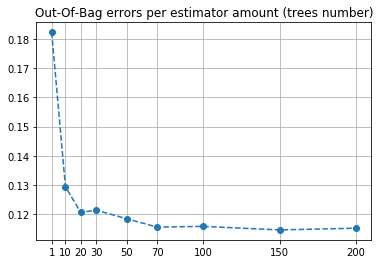

In [45]:
plt.title("Out-Of-Bag errors per estimator amount (trees number)")
plt.errorbar(n_trees,oob_errors, fmt='--o');
plt.xticks(n_trees)
plt.grid()

In [46]:
optimal_treeNum = 70

In [47]:
nrf = NumericalRandomForest_regressor(optimal_treeNum)
nrf.fit(data, values, depth=200, minElems_perLeaf=5);

#nrf.sort_featureImportances(columns=pred_features.columns)
nrf.sort_featureImportances()

[(59, 1.0324697360182316),
 (46, 0.9501820425999326),
 (6, 0.8027075447990873),
 (67, 0.7460178291662212),
 (7, 0.6828367152758542),
 (45, 0.6605634948096212),
 (1, 0.6443206728117242),
 (12, 0.6398648381175449),
 (29, 0.6245744381376619),
 (68, 0.6135031338280418),
 (22, 0.591737935292074),
 (77, 0.5735896581501585),
 (9, 0.5602888843884484),
 (20, 0.5533693677930624),
 (14, 0.5502786530873589),
 (53, 0.5332430728043577),
 (78, 0.5266444764191189),
 (50, 0.5262819557610406),
 (72, 0.5174803111260187),
 (3, 0.5018575312676186),
 (26, 0.4997231846246166),
 (95, 0.4922683811625809),
 (15, 0.47499602856075596),
 (2, 0.464708303627629),
 (37, 0.46387252249510247),
 (80, 0.45427983324538534),
 (43, 0.4495669910957512),
 (23, 0.4488090769958122),
 (81, 0.43255032585895536),
 (47, 0.4287891712443699),
 (74, 0.4197445660059704),
 (60, 0.4114307357546956),
 (63, 0.4087046424194468),
 (8, 0.4086781944662097),
 (18, 0.40105809531999587),
 (0, 0.3990437963136303),
 (21, 0.3986826711690904),
 (40, 

In [48]:
pred = nrf.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.016983399872329292
Root Mean Square Error: 0.13032476370602092
R^2 score: 0.629064713386867


### Random Forest SkLearn class

In [49]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=optimal_treeNum)
# oob error not working, need to perform evaluation on test split
rfr.fit(trainVal_data, trainVal_values.ravel())

np.flip(np.argsort(rfr.feature_importances_))

array([ 44,  43,  46,  92,  41,  40,  68,  38,  71,  97,  49,  79,  98,
         2,  72,  21,  25,  75,  76,  86,   3,  22,  99,  45,  94,  27,
        14,  37,  77,   4,  55,   0,  24,  69,  34,  26,  18,   5,  74,
        50,  35,  96,  23,   8,  33, 100,  89,  90,  66,  12,  48,  28,
        78,  32,  39,  88,  91,  47,  95,   1,  84,   6,  17,  67,  29,
         7,  15,  61,  65,  36,  52,  62,  31,  30,  82,  60,  51,  73,
        53,  42,  19,  54,  83,  56,  87,  20,  59,  93,  16,  63,  13,
         9,  81,  64,  57,  80,  10,  85,  58, 101,  11,  70])

In [50]:
pred = rfr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.026336088104431592
Root Mean Square Error: 0.1622893295156629
R^2 score: 0.4247929651812137


# Predictors - Models definition

## 1. Regularised Least Squares
   

In [51]:
class tikhonov_leastSquares:
    def __init__(self, weights = None):
        self.weights = weights
        
    def fit(self, X, y, _lambda):
        inv = np.linalg.inv(np.matmul(X.T, X) + _lambda*np.eye(X.shape[1]))
        self.weights = np.matmul(inv, np.matmul(X.T, y))
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights.flatten()), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights.flatten()), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [52]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, tls)[0]
print("Best regulariser: {}".format(win_regulariser))
tls.fit(trainVal_data, trainVal_values, win_regulariser)
pred = tls.predict(test_data)

remRLS = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(remRLS.resVariance))
print("Root Mean Square Error: {}".format(remRLS.rootMeanSquareError()))
print("R^2 score: {}".format(remRLS.rSquared()))

Best regulariser: 2
Residual variance: 0.02389355920558821
Root Mean Square Error: 0.15489396450283655
R^2 score: 0.47602176438699284


## 2. Random Forest

In [53]:
rf = NumericalRandomForest_regressor(optimal_treeNum)
rf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5);

pred = rf.predict(test_data)
remRF = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(remRF.resVariance))
print("Root Mean Square Error: {}".format(remRF.rootMeanSquareError()))
print("R^2 score: {}".format(remRF.rSquared()))

Residual variance: 0.025783531022747833
Root Mean Square Error: 0.16063634641268945
R^2 score: 0.4364507288886089


In [54]:
rf.oob_error

0.10986500311886391

In [55]:
rf.sort_featureImportances()

[(75, 0.5660330716014033),
 (77, 0.5509766176666522),
 (44, 0.524184979817669),
 (0, 0.5064902552352094),
 (27, 0.4963870284479601),
 (3, 0.49081416898091745),
 (67, 0.48179688693912326),
 (5, 0.4687911822337159),
 (78, 0.45697400788994325),
 (20, 0.42878910006720294),
 (69, 0.4212048022931632),
 (18, 0.4141543064696828),
 (34, 0.4039417756643824),
 (49, 0.4011075020433033),
 (15, 0.3810785615433902),
 (66, 0.3735876112955327),
 (89, 0.3714615775636096),
 (43, 0.36488202106841106),
 (50, 0.3523464065528712),
 (9, 0.3483682938932742),
 (47, 0.3422695297619008),
 (22, 0.3275455452112097),
 (85, 0.3189693958337049),
 (88, 0.3178876239634233),
 (40, 0.3168654190058339),
 (68, 0.31588176605348445),
 (14, 0.3108337301668055),
 (62, 0.3055888823095706),
 (28, 0.30312732579092805),
 (25, 0.2980761921280591),
 (71, 0.29698605742270767),
 (57, 0.2886339623178811),
 (17, 0.2881215362569882),
 (6, 0.28181190606887724),
 (52, 0.28170513977939193),
 (29, 0.2668057488292015),
 (55, 0.2639205960818987

## 3. Kernel Least Squares

In [56]:
from sklearn.metrics import pairwise_distances

class kernel:        
    def gaussian(X, y=None, param=None):
        if param is None:
            param = 1/X.shape[1]
            
        if y is None:
            Q = np.exp(-param*np.square(pairwise_distances(X)))
        else:
            Q = np.exp(-param*np.square(pairwise_distances(X, y)))
        return Q

In [57]:
class kernelTikhonov_leastSquares:
    def __init__(self, kernel_func, alphas=None):
        self.kernel_func = kernel_func
        self.alphas = alphas
        self.train_set = None
        
    def fit(self, X, y, _lambda, k_parameter):
        self.train_set = X
        
        Q = self.kernel_func(X, param=k_parameter)
        inv = np.linalg.inv(Q + _lambda*np.eye(X.shape[0]))
        self.alphas = np.matmul(inv, y)
        
        return self
    
    def predict(self, X):
        if self.alphas is None:
            raise Exception("weights not initialised! need to first fit the model")
        
        return np.matmul(self.kernel_func(X, self.train_set), self.alphas)

In [58]:
k = 5
params_dict = {"_lambda":[0.01,0.1,0.5,1,1.3,1.5], "k_parameter":[0.001, 0.01, 0.05, 0.1, 1]}

ktls = kernelTikhonov_leastSquares(kernel_func=kernel.gaussian)

win_parameters = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, ktls)
print("Best regulariser: {}".format(win_parameters))
ktls.fit(trainVal_data, trainVal_values, _lambda=win_parameters[0], k_parameter=win_parameters[1])

pred = ktls.predict(test_data)
remKLS = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(remKLS.resVariance))
print("Root Mean Square Error: {}".format(remKLS.rootMeanSquareError()))
print("R^2 score: {}".format(remKLS.rSquared()))

Best regulariser: (0.1, 0.01)
Residual variance: 0.022872348291174793
Root Mean Square Error: 0.16816743283170305
R^2 score: 0.3823704791308208


# Recursive Features Elimination
<img src="img/Algo1.png">

In [59]:
nrf = NumericalRandomForest_regressor(optimal_treeNum)
nrf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5, verbose=False);

In [60]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances()

Features sorted by their score:



[(50, 0.6940471558006951),
 (20, 0.5220992494702621),
 (52, 0.46150918280341297),
 (68, 0.4589382666069003),
 (94, 0.445034957480652),
 (38, 0.43620307235897415),
 (18, 0.4267148661219282),
 (8, 0.42412852677977664),
 (44, 0.4014331395432281),
 (34, 0.3937056766008874),
 (35, 0.3907589190734284),
 (15, 0.38797209637556784),
 (26, 0.3708129871755626),
 (55, 0.3624510306661201),
 (60, 0.35856989124132305),
 (54, 0.3547402267198883),
 (6, 0.35135012352591766),
 (27, 0.34948903977073825),
 (0, 0.3491994278038613),
 (90, 0.3394910939604117),
 (45, 0.3387273743129928),
 (75, 0.3353662748697982),
 (78, 0.3348325719168268),
 (99, 0.33109313849867816),
 (33, 0.3299908324100011),
 (4, 0.31352398971930484),
 (30, 0.3111961241935074),
 (67, 0.30151100583675317),
 (7, 0.300641660430568),
 (98, 0.2999315918859464),
 (97, 0.2974489647855536),
 (12, 0.2959044448576333),
 (47, 0.2936717715039954),
 (85, 0.28620915273093145),
 (58, 0.2859196204011175),
 (71, 0.27835650249338234),
 (36, 0.276451124016849

In [61]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances(columns=pred_features.columns)

Features sorted by their score:



[('PctKidsBornNeverMar', 0.694),
 ('perCapInc', 0.5221),
 ('PctImmigRecent', 0.4615),
 ('PctPersDenseHous', 0.4589),
 ('PctBornSameState', 0.445),
 ('MalePctDivorce', 0.4362),
 ('pctWRetire', 0.4267),
 ('agePct16t24', 0.4241),
 ('PctKids2Par', 0.4014),
 ('PctEmplManu', 0.3937),
 ('PctEmplProfServ', 0.3908),
 ('pctWInvInc', 0.388),
 ('HispPerCap', 0.3708),
 ('PctImmigRec10', 0.3625),
 ('PctSpeakEnglOnly', 0.3586),
 ('PctImmigRec8', 0.3547),
 ('agePct12t21', 0.3514),
 ('NumUnderPov', 0.3495),
 ('population', 0.3492),
 ('MedOwnCostPctIncNoMtg', 0.3395),
 ('PctYoungKids2Par', 0.3387),
 ('PctVacMore6Mos', 0.3354),
 ('PctWOFullPlumb', 0.3348),
 ('PopDens', 0.3311),
 ('PctEmploy', 0.33),
 ('racePctAsian', 0.3135),
 ('PctNotHSGrad', 0.3112),
 ('PctPersOwnOccup', 0.3015),
 ('agePct12t29', 0.3006),
 ('LandArea', 0.2999),
 ('PctSameState85', 0.2974),
 ('medIncome', 0.2959),
 ('PctWorkMomYoungKids', 0.2937),
 ('RentHighQ', 0.2862),
 ('PctRecImmig8', 0.2859),
 ('HousVacant', 0.2784),
 ('PctOccupMan

### Project RFE method definition

In [62]:
def rfe(estimator, parameters_dict, data, vals, n_features=None, verbose=False):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
    train_feat = list(range(d))    
    rmse = []
    r2 = []
    feature_tracking = {}

    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    while d >= nf:
        if verbose:
            update = round((data.shape[1]-d)*100/(data.shape[1]-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
            
        estimator.fit(X=tr_data[:,train_feat], y=tr_vals, **parameters_dict)
        pred = estimator.predict(ts_data[:,train_feat])
        
        rem = Regression_evaluationMetric(ts_vals, pred)
        rmse.append(rem.rootMeanSquareError())
        r2.append(rem.rSquared())
        
        rank = estimator.sort_featureImportances()
        feature_tracking[d] = [pair[0] for pair in rank] #map(lambda pair:pair[0], rank)
        toDiscard_idx = rank[-1][0]
        train_feat.remove(train_feat[toDiscard_idx])

        d -= 1
    
    return (rmse, r2, feature_tracking)

In [63]:
sel_features = 10

In [64]:
p_dict = {"depth":300, "minElems_perLeaf":5, "post_pruning":True, "verbose":False}
rootMSE, r2, track_feature = rfe(NumericalRandomForest_regressor(optimal_treeNum),
                                p_dict, trainVal_data, trainVal_values, n_features=sel_features, verbose=True)

	[                    ] 0.0%
	[                   ] 1.09%
	[                   ] 2.17%
	[                   ] 3.26%
	[                   ] 4.35%
	[#                  ] 5.43%
	[#                  ] 6.52%
	[#                  ] 7.61%
	[#                  ] 8.7%
	[#                  ] 9.78%
	[##                 ] 10.87%
	[##                 ] 11.96%
	[##                 ] 13.04%
	[##                 ] 14.13%
	[###                ] 15.22%
	[###                ] 16.3%
	[###                ] 17.39%
	[###                ] 18.48%
	[###                ] 19.57%
	[####               ] 20.65%
	[####               ] 21.74%
	[####               ] 22.83%
	[####               ] 23.91%
	[#####               ] 25.0%
	[#####              ] 26.09%
	[#####              ] 27.17%
	[#####              ] 28.26%
	[#####              ] 29.35%
	[######             ] 30.43%
	[######             ] 31.52%
	[######             ] 32.61%
	[######             ] 33.7%
	[######             ] 34.78%
	[#######            ] 

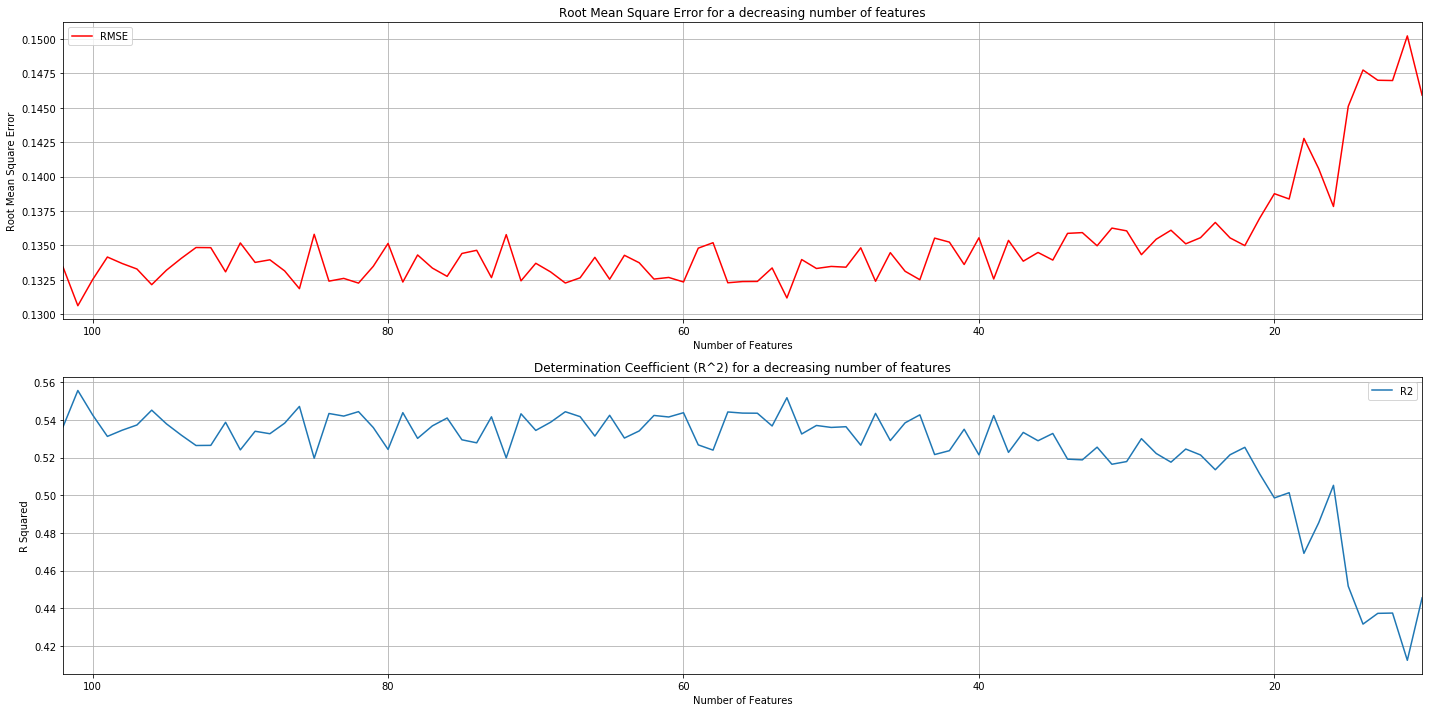

In [65]:
surv_feature = track_feature[sel_features]
x = range(trainVal_data.shape[1],len(surv_feature)-1,-1)

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title("Root Mean Square Error for a decreasing number of features")
plt.plot(x, rootMSE,"r", label="RMSE")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.grid()

plt.subplot(212)
plt.title("Determination Ceefficient (R^2) for a decreasing number of features")
plt.plot(x, r2, label="R2")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("R Squared")
plt.legend()
plt.grid()

plt.tight_layout()

### RFE SkLearn class

In [66]:
from sklearn.feature_selection import RFE
def rfe_sklearn(estimator, data, vals, n_features=None, verbose=True):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
      
    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    rfe_sk = RFE(estimator, n_features_to_select=nf, verbose=verbose)
    rfe_sk.fit(tr_data, tr_vals.flatten())
    sorted_var = np.argsort(rfe_sk.ranking_)
    
    
    print("Feature ranking ended, now fitting with decreasing amount")
    rmse = []
    r2 = []
    
    estimator.fit(tr_data, tr_vals.flatten())
    pred = estimator.predict(ts_data)
    rem = Regression_evaluationMetric(ts_vals, pred)
    rmse.append(rem.rootMeanSquareError())
    r2.append(rem.rSquared())
        
    for excluded in range(1, d-nf):
        if verbose:
            update = round(excluded*100/(d-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
        
        estimator.fit(tr_data[:,sorted_var[:-excluded]], tr_vals.flatten())
        pred = estimator.predict(ts_data[:,sorted_var[:-excluded]])
        
        rem = Regression_evaluationMetric(ts_vals, pred)
        rmse.append(rem.rootMeanSquareError())
        r2.append(rem.rSquared())
    
    return (rmse, r2, rfe_sk.ranking_)

In [67]:
rootMSE, r2, ranking = rfe_sklearn(RandomForestRegressor(n_estimators=optimal_treeNum), trainVal_data, 
                                   trainVal_values, n_features=sel_features)

Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75

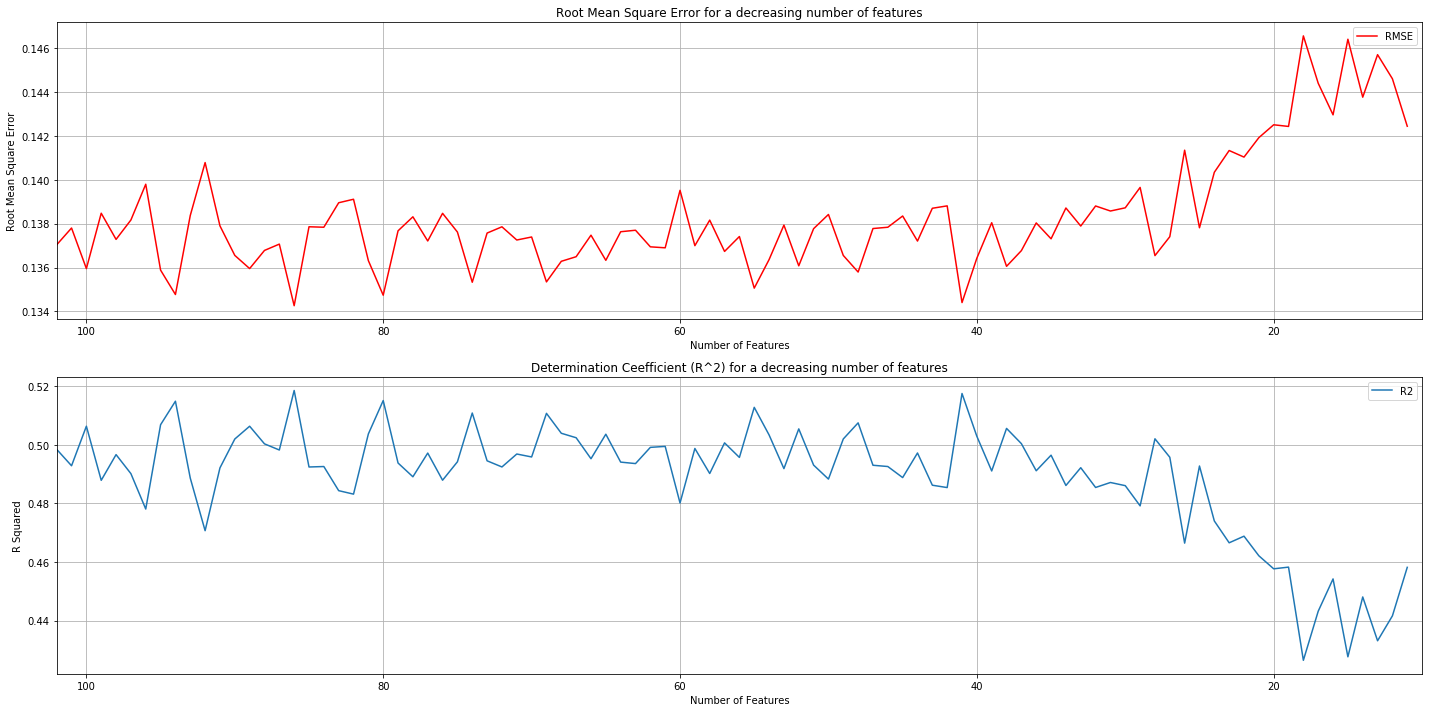

In [68]:
surv_feature = np.where(ranking==1)[0]
x = range(trainVal_data.shape[1],len(surv_feature),-1)

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title("Root Mean Square Error for a decreasing number of features")
plt.plot(x, rootMSE,"r", label="RMSE")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.grid()

plt.subplot(212)
plt.title("Determination Ceefficient (R^2) for a decreasing number of features")
plt.plot(x, r2, label="R2")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("R Squared")
plt.legend()
plt.grid()

plt.tight_layout()

### Select the features amount

In [69]:
best_features = track_feature[40]

# Applying the RFE results

## 1. Regularised Least Squares
   

In [70]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2.5,3,3.5,4]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data[:,best_features],
                                                      trainVal_values, tls)[0]
print("Best regulariser: {}\n".format(win_regulariser))
tls.fit(trainVal_data[:,best_features], trainVal_values, win_regulariser)
pred = tls.predict(test_data[:,best_features])

rem = Regression_evaluationMetric(test_values, pred)

print("Before RFE metrics were:")
print("Residual variance: {}".format(remRLS.resVariance))
print("Root Mean Square Error: {}".format(remRLS.rootMeanSquareError()))
print("R^2 score: {}\n".format(remRLS.rSquared()))

print("Now are:")
print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Best regulariser: 2.5

Before RFE metrics were:
Residual variance: 0.02389355920558821
Root Mean Square Error: 0.15489396450283655
R^2 score: 0.47602176438699284

Now are:
Residual variance: 0.02555488609906338
Root Mean Square Error: 0.16010428419068454
R^2 score: 0.44017773975859464


## 2. Random Forest

In [71]:
rf = NumericalRandomForest_regressor(optimal_treeNum)
rf.fit(trainVal_data[:,best_features], trainVal_values, depth=200, minElems_perLeaf=5);

pred = rf.predict(test_data[:,best_features])
rem = Regression_evaluationMetric(test_values, pred)

print("Before RFE metrics were:")
print("Residual variance: {}".format(remRF.resVariance))
print("Root Mean Square Error: {}".format(remRF.rootMeanSquareError()))
print("R^2 score: {}\n".format(remRF.rSquared()))

print("Now are:")
print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Before RFE metrics were:
Residual variance: 0.025783531022747833
Root Mean Square Error: 0.16063634641268945
R^2 score: 0.4364507288886089

Now are:
Residual variance: 0.02834454152014012
Root Mean Square Error: 0.16845824853273278
R^2 score: 0.3802324709998016


## 3. Kernel Least Squares

In [80]:
k = 5
params_dict = {"_lambda":[1.3,1.5,1.6,1.7,1.8,2], "k_parameter":[0.01,0.03,0.04,0.05,0.1,1]}

ktls = kernelTikhonov_leastSquares(kernel_func=kernel.gaussian)

win_parameters = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data[:,best_features],
                                                     trainVal_values, ktls)
print("Best regulariser: {}\n".format(win_parameters))
ktls.fit(trainVal_data[:,best_features], trainVal_values, _lambda=win_parameters[0], k_parameter=win_parameters[1])

pred = ktls.predict(test_data[:,best_features])
rem = Regression_evaluationMetric(test_values, pred)

print("Before RFE metrics were:")
print("Residual variance: {}".format(remKLS.resVariance))
print("Root Mean Square Error: {}".format(remKLS.rootMeanSquareError()))
print("R^2 score: {}\n".format(remKLS.rSquared()))

print("Now are:")
print("Residual variance: {}".format(rem.resVariance))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Best regulariser: (1.7, 0.03)

Before RFE metrics were:
Residual variance: 0.022872348291174793
Root Mean Square Error: 0.16816743283170305
R^2 score: 0.3823704791308208

Now are:
Residual variance: 0.026970845072519945
Root Mean Square Error: 0.21859294094145965
R^2 score: -0.04355783485062448
